# SEA 820 NLP Final Project: Detecting AI-Generated Text
- Dennis Audu
- 148463193

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/sea820_proj') # set colab project directory, so it can read other files

In [4]:
from utils import test_google_colab

test_google_colab()

tested!


In [5]:
# Loading dataset from kaggle

path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

files = os.listdir(path)
df = pd.read_csv(os.path.join(path, "AI_Human.csv"))

print(df.shape)
df.head()

(487235, 2)


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


#### Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [7]:
# Check for missing values, data types, and duplicates to ensure clean dataset
print(df.info())
print("\n")
print(df.isnull().sum())
print("\n")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB
None


text         0
generated    0
dtype: int64


Number of duplicate rows: 0


Word count statistics:
Mean: 393.1
Median: 363.0
Min: 0
Max: 1668


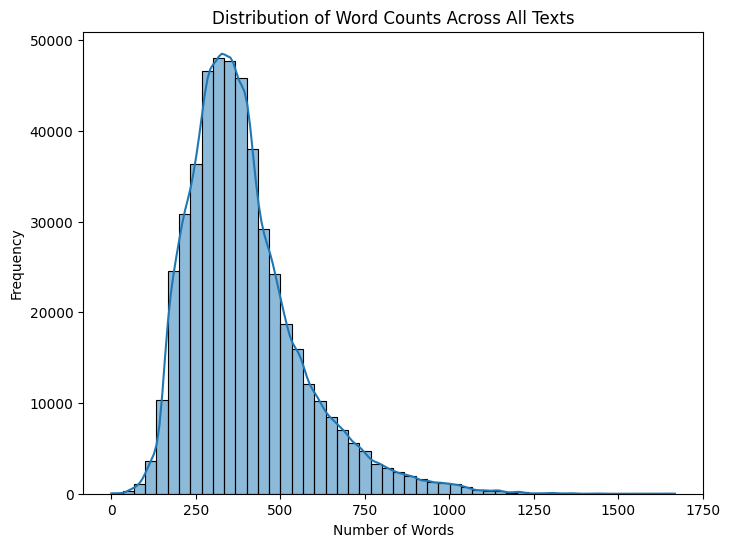

In [8]:
# Text Length Analysis
# Analyze the distribution of text lengths to understand dataset characteristics
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

print(f"Word count statistics:")
print(f"Mean: {df['word_count'].mean():.1f}")
print(f"Median: {df['word_count'].median():.1f}")
print(f"Min: {df['word_count'].min()}")
print(f"Max: {df['word_count'].max()}")

# Visualize word count distribution
plt.figure(figsize=(8,6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts Across All Texts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

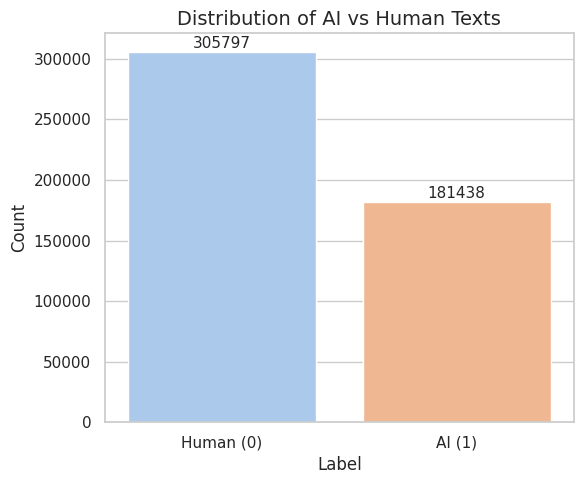

In [9]:
# Class Distribution
sns.set(style="whitegrid")
label_counts = df['generated'].value_counts().sort_index()
label_names = ['Human (0)', 'AI (1)']

plt.figure(figsize=(6, 5))

sns.barplot(
    x=label_names,
    y=label_counts.values,
    hue=label_names,
    palette='pastel',
    legend=False
)

plt.title('Distribution of AI vs Human Texts', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

for i, count in enumerate(label_counts.values):
    plt.text(i, count + 1000, str(count), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

In [10]:
# Examine systematic differences between AI-generated and human-written texts
ai_texts = df[df['generated'] == 1]['text']
human_texts = df[df['generated'] == 0]['text']

print(f"Average AI text length: {ai_texts.str.len().mean():.1f} characters")
print(f"Average Human text length: {human_texts.str.len().mean():.1f} characters")
print(f"Difference: {abs(ai_texts.str.len().mean() - human_texts.str.len().mean()):.1f} characters")


print(f"\nAI-generated texts: {len(ai_texts):,} ({len(ai_texts)/len(df)*100:.1f}%)")
print(f"Human-written texts: {len(human_texts):,} ({len(human_texts)/len(df)*100:.1f}%)")
print(f"Dataset balance: {'Balanced' if abs(len(ai_texts) - len(human_texts))/len(df) < 0.1 else 'Imbalanced'}")

Average AI text length: 2126.3 characters
Average Human text length: 2354.6 characters
Difference: 228.3 characters

AI-generated texts: 181,438 (37.2%)
Human-written texts: 305,797 (62.8%)
Dataset balance: Imbalanced


### Preprocessing

In [11]:
import pickle
import re
import string
from tqdm import tqdm
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import spacy

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# These functions extract linguistic features to distinguish AI-generated from human text

def preprocess_text(text):
    doc = nlp(text)
    # Extract meaningful tokens: lemmatized, lowercase, no stopwords/punctuation
    tokens = [token.lemma_.lower()
              for token in doc
              if not token.is_stop and token.is_alpha]
    return " ".join(tokens)


def get_sentence_lengths(text):
    """
    Extract word counts for each sentence in the text.
    Sentences are split on periods, exclamation marks, and question marks.
    """
    sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    return [len(s.split()) for s in sentences] if sentences else [0]

def avg_sentence_length(text):
    """
    Calculate average sentence length in words.
    Shorter sentences might indicate simpler AI generation patterns.
    """
    lengths = get_sentence_lengths(text)
    return np.mean(lengths) if lengths else 0

def sentence_length_std(text):
    """
    Calculate standard deviation of sentence lengths.
    High variation might indicate more natural human writing patterns.
    """
    lengths = get_sentence_lengths(text)
    return np.std(lengths) if lengths else 0

def max_sentence_length(text):
    """
    Find the longest sentence in the text.
    Extremely long sentences might be characteristic of AI generation.
    """
    lengths = get_sentence_lengths(text)
    return np.max(lengths) if lengths else 0

def punctuation_density(text):
    """
    Calculate ratio of punctuation marks to total words.
    Different punctuation patterns might distinguish AI from human text.
    """
    punct_count = sum(1 for ch in text if ch in string.punctuation)
    word_count = len(text.split()) or 1
    return punct_count / word_count

def stopword_ratio(text):
    """
    Calculate the ratio of stopwords to total words.
    AI might use different patterns of function words (the, and, of, etc.).
    """
    tokens = text.split()
    if not tokens:
        return 0
    stop_count = sum(1 for tok in tokens if tok.lower() in stop_words)
    return stop_count / len(tokens)

def pos_ratios(text):
    """
    Calculate ratios of different parts of speech (POS).
    AI and humans might use different distributions of nouns, verbs, etc.

    Returns ratios for: nouns, verbs, adjectives, adverbs, pronouns
    """
    doc = nlp(text)
    total_tokens = len([t for t in doc if t.is_alpha])
    if total_tokens == 0:
        return {"noun_ratio": 0, "verb_ratio": 0, "adj_ratio": 0, "adv_ratio": 0, "pron_ratio": 0}

    counts = {
        "noun_ratio": sum(1 for t in doc if t.pos_ == "NOUN") / total_tokens,
        "verb_ratio": sum(1 for t in doc if t.pos_ == "VERB") / total_tokens,
        "adj_ratio": sum(1 for t in doc if t.pos_ == "ADJ") / total_tokens,
        "adv_ratio": sum(1 for t in doc if t.pos_ == "ADV") / total_tokens,
        "pron_ratio": sum(1 for t in doc if t.pos_ == "PRON") / total_tokens,
    }
    return counts

def extract_numerical_features(df):
    """
    Extract all linguistic features from the dataset.
    This creates a comprehensive feature matrix for the classical ML model.
    """

    features = pd.DataFrame()

    # Sentence-level features
    print("- Sentence length features")
    features["avg_sentence_length"] = df["text"].progress_apply(avg_sentence_length)
    features["sentence_length_std"] = df["text"].progress_apply(sentence_length_std)
    features["max_sentence_length"] = df["text"].progress_apply(max_sentence_length)

    # Lexical features
    print("- Lexical features")
    features["punctuation_density"] = df["text"].progress_apply(punctuation_density)
    features["stopword_ratio"] = df["text"].progress_apply(stopword_ratio)

    # Syntactic features (POS ratios)
    print("- Part-of-speech features")
    pos_df = df["text"].progress_apply(lambda x: pd.Series(pos_ratios(x)))
    features = pd.concat([features, pos_df], axis=1)

    print(f"Feature extraction complete. Shape: {features.shape}")
    return features

In [13]:
# Data Persistence Functions
# Save and load preprocessed data to avoid recomputing expensive operations
def save_corpus_and_features(df, corpus_path="tokens.pkl", features_path="features.pkl"):
    """
    Preprocess texts and extract features, then save both as pickle files.
    This saves time on subsequent runs by avoiding recomputation. Initially took over 830 minutes to run.
    """
    if os.path.exists(corpus_path) and os.path.exists(features_path):
        print(f"Corpus and features already exist at {corpus_path} and {features_path}")
        return

    # Preprocess all texts for TF-IDF vectorization
    corpus = df["text"].progress_apply(preprocess_text).tolist()

    # Extract numerical features for classical ML model
    features = extract_numerical_features(df)

    # Save processed data
    with open(corpus_path, "wb") as f:
        pickle.dump(corpus, f)
    with open(features_path, "wb") as f:
        pickle.dump(features, f)

    print(f"Corpus saved to {corpus_path}")
    print(f"Features saved to {features_path}")

def load_corpus_and_features(corpus_path="tokens.pkl", features_path="features.pkl"):

    if not (os.path.exists(corpus_path) and os.path.exists(features_path)):
        raise FileNotFoundError(f"Preprocessed files not found: {corpus_path}, {features_path}")

    with open(corpus_path, "rb") as f:
        corpus = pickle.load(f)

    with open(features_path, "rb") as f:
        features = pickle.load(f)

    return corpus, features

### Training Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

In [15]:
# Execute preprocessing pipeline
save_corpus_and_features(df)

Corpus and features already exist at tokens.pkl and features.pkl


### Data Split and Feature Extraction

In [16]:
corpus, features = load_corpus_and_features()

tfidf = TfidfVectorizer(
    max_features=1000,        # Limit vocabulary size for computational efficiency
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2)
)
X_tfidf = tfidf.fit_transform(corpus)
X_stats = features

# Combine sparse TF-IDF features with dense statistical features
# This creates a hybrid feature representation
X = hstack([X_tfidf, X_stats.values])
y = df["generated"]

# Train/test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (389788, 1010), Test set: (97447, 1010)


### Training

In [17]:
# Initialize Random Forest with carefully tuned hyperparameters
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
print("Training complete")

Training complete


#### Evaluation


Classification Report:
               precision    recall  f1-score   support

Human-written       0.92      0.99      0.96     61159
 AI-generated       0.99      0.86      0.92     36288

     accuracy                           0.95     97447
    macro avg       0.96      0.93      0.94     97447
 weighted avg       0.95      0.95      0.94     97447


Confusion Matrix:


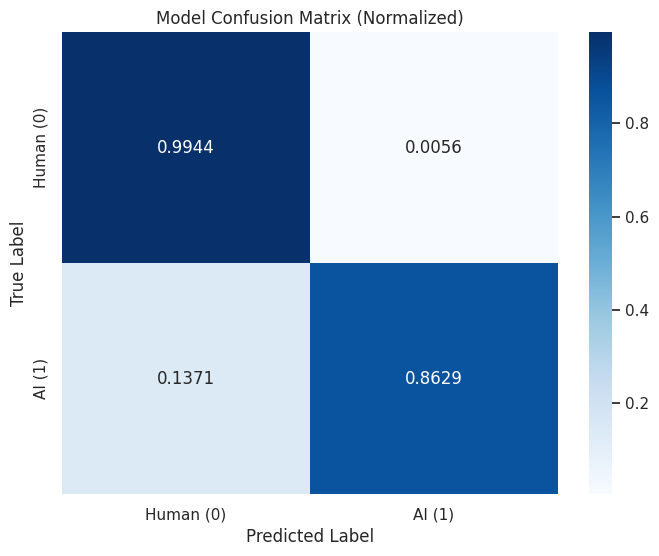


Summary:
Total test samples: 97447
Correct predictions: 92131
Accuracy: 0.9454


In [18]:
from utils import evaluate_model_performance

# Predictions
y_pred = clf.predict(X_test)
evaluate_model_performance(y_test, y_pred)

##### Manual Testing

In [19]:
from scipy.sparse import hstack, vstack, csr_matrix
from utils import get_text_to_predict

# Set of texts, that are not in the training set for manual testing
text_to_predict = get_text_to_predict()

def extract_features(text):
    tfidf_vec = tfidf.transform([text])  # sparse
    num_feats = [
        avg_sentence_length(text),
        sentence_length_std(text),
        max_sentence_length(text),
        punctuation_density(text),
        stopword_ratio(text)
    ]
    pos_feats = list(pos_ratios(text).values())
    numerical_array = np.array(num_feats + pos_feats).reshape(1, -1)

    # convert dense numerical block to sparse, and force CSR output
    numerical_sparse = csr_matrix(numerical_array)
    combined = hstack([tfidf_vec, numerical_sparse], format="csr")
    return combined

print("Classifier predictions:")
for i, sample in enumerate(text_to_predict):
    # Extract features from the text
    features = extract_features(sample["text"])

    pred_class = clf.predict(features)[0]
    actual_class = sample["label"]

    # Get prediction probabilities for confidence
    pred_proba = clf.predict_proba(features)[0]
    confidence = max(pred_proba)

    print(f"{i+1} Predicted: {pred_class:<10} Probability: {confidence:<10.3f} Actual: {actual_class:<10}")

Classifier predictions:
1 Predicted: 1.0        Probability: 0.618      Actual: 1         
2 Predicted: 1.0        Probability: 0.747      Actual: 1         
3 Predicted: 1.0        Probability: 0.855      Actual: 1         
4 Predicted: 1.0        Probability: 0.642      Actual: 0         
5 Predicted: 0.0        Probability: 0.578      Actual: 0         
6 Predicted: 0.0        Probability: 0.584      Actual: 0         


### Transformer Fine-Tuning with DistilBERT

In [20]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [21]:
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType,PeftModel
from evaluate import load
import numpy as np
import inspect
from utils import setup_device

device = setup_device()
torch.manual_seed(42)
if device.type == "mps":
    torch.mps.empty_cache()

Using CUDA


#### Data Split

In [68]:
# Prepare dataset with integer labels
df['generated'] = df['generated'].astype(int)
hf_dataset = Dataset.from_pandas(df[['text', 'generated']])
hf_dataset = hf_dataset.rename_column("generated", "labels")

# Split dataset
dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = dataset["train"]
test_ds = dataset["test"]

#### Tokenization

In [69]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_func(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenize datasets
tokenized_train = train_ds.map(tokenize_func, batched=True, batch_size=1000)
tokenized_test = test_ds.map(tokenize_func, batched=True, batch_size=1000)

# Format labels in batches
def format_labels(batch):
    batch['labels'] = [int(l) for l in batch['labels']]
    return batch

tokenized_train = tokenized_train.map(format_labels, batched=True)
tokenized_test = tokenized_test.map(format_labels, batched=True)

# Set dataset format for PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/389788 [00:00<?, ? examples/s]

Map:   0%|          | 0/97447 [00:00<?, ? examples/s]

Map:   0%|          | 0/389788 [00:00<?, ? examples/s]

Map:   0%|          | 0/97447 [00:00<?, ? examples/s]

#### Load Model

In [70]:
# Load DistilBERT model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin", "k_lin", "out_lin"]
)

# Apply LoRA to the model
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()
model.to(device)

trainable params: 1,181,954 || all params: 68,136,964 || trainable%: 1.7347


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76

#### Training

In [73]:
# Metrics setup
accuracy_metric = load("accuracy")
f1_metric = load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels)
    return {**acc, **f1}


# Training function
def train_distilbert_lora(learning_rate, batch_size, epochs, exp_name):
    from transformers import Trainer, EarlyStoppingCallback

    class CustomTrainer(Trainer):
        def _prepare_inputs(self, inputs):
            inputs = super()._prepare_inputs(inputs)
            inputs.pop("num_items_in_batch", None)
            return inputs

    training_args = TrainingArguments(
        output_dir=f"./results/distilbert_lora_{exp_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=f"./logs/distilbert_lora_{exp_name}",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=2,
        warmup_steps=500,
        dataloader_pin_memory=False
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,  # Use tokenizer instead of processing_class for compatibility
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train the model
    trainer.train()

    # Evaluate
    results = trainer.evaluate(tokenized_test)
    return results, trainer

In [74]:
from utils import save_model, load_model # utility functions to save and load the model
model, tokenizer = load_model()

Using CUDA
Model path does not exist: saved_model/distilbert_lora_final


In [80]:
# Training the albert lora model

isCurrentlyTrained = False # checks if the model is already trained, to skip saving

if not model:
    # used other params, but best was lr: 2e-4, bs: 16, epochs: 3

    distilbert_params = [
        # {"lr": 2e-5, "bs": 16, "epochs": 4, "name": "distilbert_lora_1"},
        # {"lr": 5e-5, "bs": 16, "epochs": 3, "name": "distilbert_lora_2"}
        {"lr": 1e-4, "bs": 32, "epochs": 2, "name": "distilbert_lora_3"}
    ]

    distilbert_log_df = pd.DataFrame()

    for param in distilbert_params:
        print(f"Running DistilBERT LoRA experiment {param['name']}...")

        # Reinitialize model for each experiment
        base_model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=2
        )
        model = get_peft_model(base_model, lora_config)
        model.to(device)

        res, trainer = train_distilbert_lora(param["lr"], param["bs"], param["epochs"], param["name"])
        res["exp_name"] = param["name"]
        res["learning_rate"] = param["lr"]
        res["batch_size"] = param["bs"]
        res["epochs"] = param["epochs"]
        distilbert_log_df = pd.concat([distilbert_log_df, pd.DataFrame([res])], ignore_index=True)

    isCurrentlyTrained = True

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running DistilBERT LoRA experiment distilbert_lora_3...


/tmp/ipython-input-3896461206.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.014200,0.012126,0.996860,0.995811
2,0.001200,0.010483,0.997219,0.996292


In [81]:
%pip install tabulate

In [82]:
from tabulate import tabulate

# saves the model, tokenizer, and model info
if isCurrentlyTrained:
    save_model(model, tokenizer)
    print("\nDistilBERT LoRA Experiment Results:\n")
    print(tabulate(distilbert_log_df, headers='keys', tablefmt='psql', showindex=False))


Saving LoRA adapter weights and config...
Saving tokenizer...
Error saving model: 'NoneType' object has no attribute 'save_pretrained'

DistilBERT LoRA Experiment Results:

+-------------+-----------------+-----------+----------------+---------------------------+-------------------------+---------+-------------------+-----------------+--------------+----------+
|   eval_loss |   eval_accuracy |   eval_f1 |   eval_runtime |   eval_samples_per_second |   eval_steps_per_second |   epoch | exp_name          |   learning_rate |   batch_size |   epochs |
|-------------+-----------------+-----------+----------------+---------------------------+-------------------------+---------+-------------------+-----------------+--------------+----------|
|   0.0104834 |        0.997219 |  0.996292 |        308.812 |                   315.554 |                   9.864 |       2 | distilbert_lora_3 |          0.0001 |           32 |        2 |
+-------------+-----------------+-----------+----------------+-

#### Evaluation

100%|██████████| 3046/3046 [05:06<00:00,  9.93it/s]



Classification Report:
               precision    recall  f1-score   support

Human-written       1.00      1.00      1.00     61014
 AI-generated       0.99      1.00      1.00     36433

     accuracy                           1.00     97447
    macro avg       1.00      1.00      1.00     97447
 weighted avg       1.00      1.00      1.00     97447


Confusion Matrix:


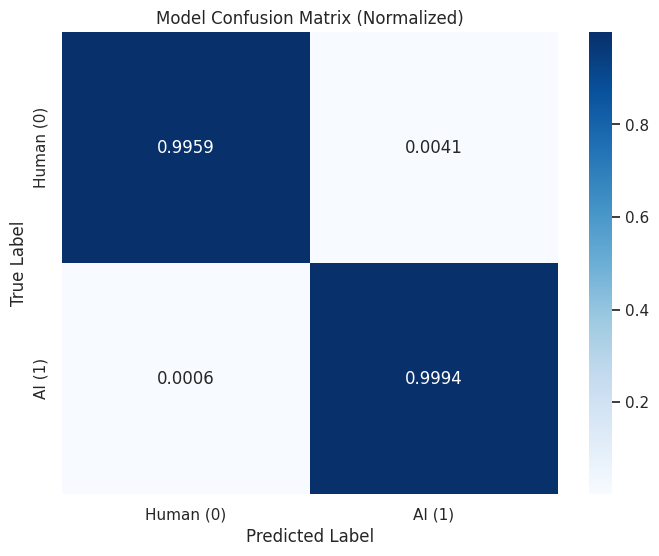


Summary:
Total test samples: 97447
Correct predictions: 97176
Accuracy: 0.9972


In [84]:
from torch.utils.data import DataLoader

# if 'model' not in locals() or not model or not tokenizer:
#     model, tokenizer = load_model()

model.eval()
all_predictions = []
all_true_labels = []

# Create DataLoader from existing tokenized_test
test_dataloader = DataLoader(tokenized_test, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Move batch to device
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels']

        # Get model predictions
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

evaluate_model_performance(all_true_labels, all_predictions)

##### Manual Testing

In [85]:
# To handle long text, we chunk the text into smaller chunks and predict the class for each chunk
def chunk_token_ids(token_ids, max_length=512, stride=50):
    chunks = []
    for i in range(0, len(token_ids), max_length - stride):
        chunk = token_ids[i:i + max_length]
        chunks.append(chunk)
    return chunks

def predict(text, model, tokenizer, device):
    model.eval()

    token_ids = tokenizer.encode(text, add_special_tokens=True, truncation=False)

    # Chunk token IDs directly
    chunks = chunk_token_ids(token_ids, max_length=512, stride=50)

    all_probs = []
    for chunk in chunks:
        input_ids = torch.tensor([chunk]).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_probs.append(probs.cpu())

    mean_probs = torch.mean(torch.stack(all_probs), dim=0)
    pred_class = torch.argmax(mean_probs, dim=-1).item()
    confidence = mean_probs[0][pred_class].item()
    return pred_class, confidence


print("DistilBERT Predictions:")

# using the text set from above
for i, sample in enumerate(text_to_predict):
    pred_class, confidence = predict(sample["text"], model, tokenizer, device)
    actual_class = sample["label"]

    print(f"{i+1} Predicted: {pred_class:<10} Probability: {confidence:<10.3f} Actual: {actual_class:<10}")


Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


DistilBERT Predictions:
1 Predicted: 1          Probability: 1.000      Actual: 1         
2 Predicted: 1          Probability: 1.000      Actual: 1         
3 Predicted: 1          Probability: 1.000      Actual: 1         
4 Predicted: 1          Probability: 1.000      Actual: 0         
5 Predicted: 1          Probability: 1.000      Actual: 0         
6 Predicted: 1          Probability: 0.808      Actual: 0         


In [112]:
text_ai = """I tried booking several bikes, but none of them unlocked. The station light turned green, but the bikes wouldn’t undock.
Please ensure I’m not charged for the time shown in the app."""

text_human = """In consideration of the return of earned premium to follow (if any) and in accordance ,vith the tenns of the policy
I/we hereby request cancellation oft he policy as identified above and effective as of 12:0 I A.M. of the date shown
above. This policy is hereby cancelled and surrendered, and the interim renewal certificate (ifany has been issued)
for same, acknowledged to be of no effect. I/We hereby release the above insurer from all liability under this
policy, including any renewal thereof, as from the aforementioned date of cancellation.
"""

text_human_2 = """I just tried to book various bikes, and none unlocked, they would go to green on the station but wouldn’t undock.
Please, I hope I won’t be charged for the time I was seeing on the app.
"""

text_human_3 = """I want to cancel the policy i have, starting at 12:01 AM on the date shown. Definitely, I’m returning any renewal certificate I got, and it won’t be valid anymore.
From that date, the insurer won’t have any responsibility under this policy or any renewal of it.
"""


for text in [text_ai, text_human, text_human_2, text_human_3]:
  pred_class, confidence = predict(text, model, tokenizer, device)
  print(f"Predicted: {pred_class:<10} Probability: {confidence:<10.3f}")

print("\n")

for text in [text_ai, text_human, text_human_2, text_human_3]:
    features = extract_features(text_human)

    pred_class = clf.predict(features)[0]
    pred_proba = clf.predict_proba(features)[0]
    confidence = max(pred_proba)

    print(f"Predicted: {pred_class:<10} Probability: {confidence:<10.3f}")

Predicted: 1          Probability: 1.000     
Predicted: 1          Probability: 1.000     
Predicted: 0          Probability: 0.998     
Predicted: 1          Probability: 1.000     


Predicted: 0.0        Probability: 0.796     
Predicted: 0.0        Probability: 0.796     
Predicted: 0.0        Probability: 0.796     
Predicted: 0.0        Probability: 0.796     
